<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# Imports

from sensemakr import sensitivity_stats
from sensemakr import bias_functions
from sensemakr import ovb_bounds
from sensemakr import ovb_plots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

In [2]:
%load_ext autoreload

In [4]:
# loads data
darfur = pd.read_csv("data/darfur.csv")
darfur.head()

,wouldvote,peacefactor,peace_formerenemies,peace_jjindiv,peace_jjtribes,gos_soldier_execute,directlyharmed,age,farmer_dar,herder_dar,pastvoted,hhsize_darfur,village,female
0,0,1.000000,1,1,1,0,0,30,0,0,1,23,Abdel Khair,0
1,0,0.706831,0,1,1,0,0,20,1,0,1,5,Abdi Dar,1
2,1,0.000000,0,0,0,1,0,45,1,0,0,15,Abu Sorog,0
3,1,0.495178,1,0,0,0,1,55,0,0,0,9,Abu Dejaj,0
4,0,0.000000,0,0,0,1,1,25,1,0,1,7,Abu Dejaj,1


In [31]:
# darfur['peacefactor']=darfur['peacefactor']*-1
# darfur.head()

In [51]:
# runs regression model
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + '\
                    'pastvoted + hhsize_darfur + female + village', data=darfur)
model = reg_model.fit()

In [76]:
# Define parameters for sensemakr
treatment = "directlyharmed"
q = 1.0
alpha = 0.05
reduce = True
benchmark_covariates=["female"]
kd = [1, 2, 3]
ky = kd

In [77]:
# Create a sensemakr object and print summary of results
s = sensemakr.Sensemakr(model, treatment, q=q, 
                        alpha=alpha, reduce=reduce, benchmark_covariates=benchmark_covariates, kd=kd)
s.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1.0 : 0.139
  Robustness Value, q = 1.0 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187309334110975 % of the residual variance of the treatment to fully account for the observed estimated effect.



In [127]:
sense_out=sensemakr.Sensemakr(model,treatment='directlyharmed',benchmark_covariates='female',r2dz_x=0.1)
bounds_check=sense_out.bounds
bounds_check.adjusted_se

0    0.023271
Name: adjusted_se, dtype: float64

In [155]:
village=[k for k in model.params.index.values if 'village' in k]
sensitivity=sensemakr.Sensemakr(model=model,treatment='directlyharmed',benchmark_covariates=[village],kd=0.3)
r2y=sensitivity_stats.group_partial_r2(model,covariates=village)
treat_model=smf.ols(formula='directlyharmed ~  age + farmer_dar + herder_dar +\
                pastvoted + hhsize_darfur + female + village', data=darfur).fit()
r2d=sensitivity_stats.group_partial_r2(treat_model,covariates=village)

In [174]:
bounds_check=ovb_bounds.ovb_partial_r2_bound(r2dxj_x = r2d, r2yxj_dx = r2y, kd = 0.3)

In [206]:
ovb_bounds.ovb_partial_r2_bound(treatment='directlyharmed', benchmark_covariates = "female",
                                    r2dxj_x = sensitivity_stats.partial_r2(model_treat, covariates = "female"),
                                    r2yxj_dx = sensitivity_stats.partial_r2(model, covariates = "female"),
                                    kd = [1,2,3])['r2dz_x'].values

array([0.00916429, 0.01832857, 0.02749286])

In [222]:
model_treat=smf.ols(formula='directlyharmed ~  age + farmer_dar + herder_dar +\
                pastvoted + hhsize_darfur + female + village', data=darfur).fit()
darfur_out=sensemakr.Sensemakr(estimate = 0.09731582,
                                    se = 0.02325654,
                                    dof = 783,
                                    treatment = "directlyharmed",
                                    benchmark_covariates = "female",
                                    r2dxj_x = sensitivity_stats.partial_r2(model_treat, covariates = "female"),
                                    r2yxj_dx = sensitivity_stats.partial_r2(model, covariates = "female"),
                                    kd = [1,2,3])

In [223]:
darfur_out.bounds

,bound_label,r2dz_x,r2yz_dx,adjusted_estimate,adjusted_se,adjusted_t,adjusted_lower_CI,adjusted_upper_CI
0,1x female,0.009164,0.124641,0.075220,0.021873,3.438903,0.032283,0.118158
1,2x female,0.018329,0.249324,0.052915,0.020350,2.600246,0.012968,0.092862
2,3x female,0.027493,0.374050,0.030396,0.018670,1.628062,-0.006253,0.067045


In [230]:
rv=sensitivity_stats.robustness_value(model=model,covariates='directlyharmed')

In [241]:
sensitivity_stats.sensitivity_stats(model=model,treatment='directlyharmed')

{'estimate': 0.0973158192849564,
 'se': 0.02325653780981115,
 't_statistic': 4.184449984808235,
 'r2yd_x': 0.021873093341109748,
 'rv_q': 0.13877635389358836,
 'rv_qa': 0.13877635389358836,
 'f2yd_x': 0.022362224361892256,
 'dof': 783}

In [122]:
df.round(8)==s.bounds.round(8)

,bound_label,r2dz_x,r2yz_dx,treatment,adjusted_estimate,adjusted_se,adjusted_t,adjusted_lower_CI,adjusted_upper_CI
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,False,True
2,True,True,True,True,True,True,True,True,True


In [123]:
s.bounds['adjusted_lower_CI'][1]

0.012968034831484954

In [124]:
df['adjusted_lower_CI'][1]

0.012968035

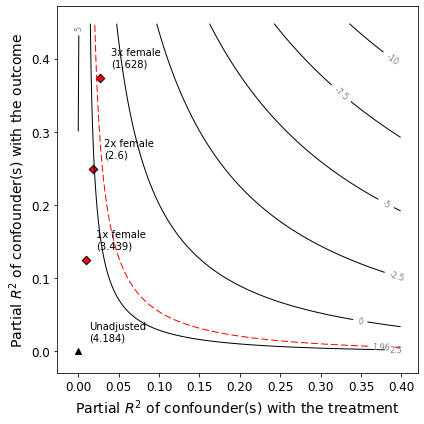

In [111]:
# Make a contour plot for the estimate
ovb_plots.ovb_contour_plot(sense_obj=s, sensitivity_of='t-value')

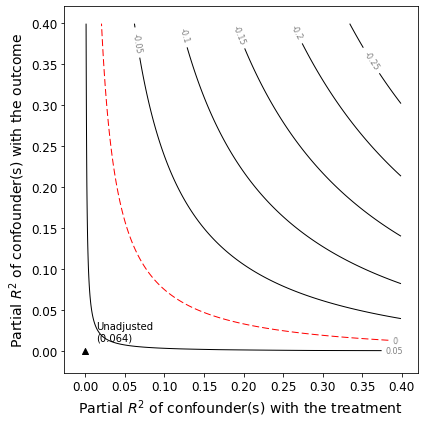

In [109]:
ovb_plots.ovb_contour_plot(model=model,treatment='directlyharmed')

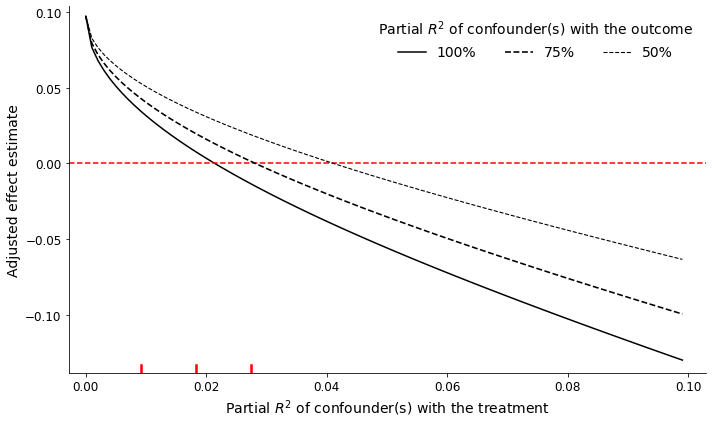

In [138]:
ovb_plots.ovb_extreme_plot(sense_obj=s)

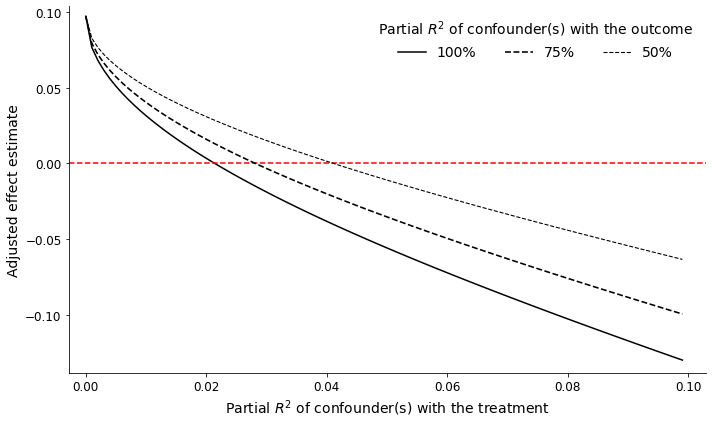

In [87]:
ovb_plots.ovb_extreme_plot(model=model,treatment='directlyharmed')

In [43]:

benchmark_covariates=["female","pastvoted"]
#list(femalepast=c('female','pastvoted'))
#dictionary list as value
#benchmark_covariates=["female"]
#{'femalepast':["female","pastvoted"]}
group_s = sensemakr.Sensemakr(model, treatment, q=q, alpha=alpha, reduce=reduce, benchmark_covariates=benchmark_covariates, kd=kd)
group_s.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1.0 : 0.139
  Robustness Value, q = 1.0 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187309334110975 % of the residual variance of the treatment to fully account for the observed estimated effect.



In [51]:
benchmark_covariates={'femalepast':["female","pastvoted"]}
#list(femalepast=c('female','pastvoted'))
#dictionary list as value
#benchmark_covariates=["female"]
#{'femalepast':["female","pastvoted"]}
group_s = sensemakr.Sensemakr(model, treatment, q=q, alpha=alpha, reduce=reduce, benchmark_covariates=benchmark_covariates, kd=kd)
group_s.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1.0 : 0.139
  Robustness Value, q = 1.0 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187309334110975 % of the residual variance of the treatment to fully account for the observed estimated effect.



In [52]:

benchmark_covariates={'femalepast':["female","pastvoted"],'femaleage':["female",'age']}
#list(femalepast=c('female','pastvoted'))
#dictionary list as value
#benchmark_covariates=["female"]
#{'femalepast':["female","pastvoted"]}
group_s = sensemakr.Sensemakr(model, treatment, q=q, alpha=alpha, reduce=reduce, benchmark_covariates=benchmark_covariates, kd=kd)
group_s.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1.0 : 0.139
  Robustness Value, q = 1.0 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187309334110975 % of the residual variance of the treatment to fully account for the observed estimated effect.



In [55]:
benchmark_covariates=[["female","pastvoted"],["female",'age']]
#list(femalepast=c('female','pastvoted'))
#dictionary list as value
#benchmark_covariates=["female"]
#{'femalepast':["female","pastvoted"]}
group_s = sensemakr.Sensemakr(model, treatment, q=q, alpha=alpha, reduce=reduce, benchmark_covariates=benchmark_covariates, kd=kd)
group_s.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1.0 : 0.139
  Robustness Value, q = 1.0 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187309334110975 % of the residual variance of the treatment to fully account for the observed estimated effect.



In [136]:
bias_functions.bias(r2dz_x=0.010153,r2yz_dx=0.134976,model=model,treatment='directlyharmed')

0.024337913419272633

In [ ]:
bias_functions.bias(r2dz_x=0.010153,r2yz_dx=0.134976,model=model,treatment='directlyharmed')

In [103]:
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age', data=darfur)
model = reg_model.fit()

In [105]:
bias_functions.bias(r2dz_x=0.1,r2yz_dx=0.1,model=model,treatment='directlyharmed')

0.073990660156656

In [113]:
model.bse['directlyharmed']

0.02325653780981115

In [119]:
bias_functions.bf(r2dz_x=0.010153,r2yz_dx=0.134976) * 0.0232565 * np.sqrt(783)  # numpy array

0.02433787385139208

In [124]:
bias_functions.bf(r2dz_x=0.01015,r2yz_dx=0.135) * 0.02325654 * np.sqrt(783)  # numpy array

0.024336409353099876

In [112]:
sensitivity_stats.model_helper(model, covariates='directlyharmed')

{'covariates': ['directlyharmed'],
 'estimate': directlyharmed    0.097316
 dtype: float64,
 'se': directlyharmed    0.023257
 dtype: float64,
 't_statistics': directlyharmed    4.18445
 dtype: float64,
 'dof': 783}

In [1]:
dic={'femalepast':["female",1],'femaleage':["female",'age']}
type(dic) is dict

True

In [80]:
any(type(j) is not str for j in dic['femalepast'])

True

['female', 1]

In [112]:
10*4*(10*4+100)

5600